In [33]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)
from scipy.stats import levy_stable
from tqdm import tqdm

import sys
sys.path.append("../../../assets")
sys.path.append("../")

from helpers import get_setup
from configurations import model_names, default_bounds
from likelihoods import _sample_diffusion_trial, sample_non_stationary_diffusion_process

In [34]:
NUM_OBS = 768
NUM_SUBS = 14
NUM_SAMPLES = 1000
HORIZON_SIZE = 68
NUM_RESIMS = 250
RNG = np.random.default_rng()

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

FONT_SIZE_1 = 24
FONT_SIZE_2 = 20
FONT_SIZE_3 = 18

LABEL_PAD = 15
LINE_WIDTH = 1.5
COLORS = [
    "#133a76", "maroon"
]
PRED_COLORS = [
    "#16abab", "#db5e0f"
]

PLOT_TITLE = ["Participant 11\nLévy Flight DDM", "Participant 6\nMixture Random Walk DDM"]

In [35]:
RESIMULATE_TIME_SERIES = False

In [36]:
def calc_sma(data, period=5):
    j = next(i for i, x in enumerate(data) if x is not None)
    our_range = range(len(data))[j + period - 1:]
    empty_list = [None] * (j + period - 1)
    sub_result = [np.mean(data[i - period + 1: i + 1]) for i in our_range]
    return np.array(empty_list + sub_result)

def post_resim(samples, num_resims):
    num_obs = samples.shape[0]
    num_samples = samples.shape[1]
    idx = np.arange(0, num_samples-1, num_samples/num_resims, dtype=np.int32)
    theta = samples[:, idx]
    pred_data = np.zeros((num_resims, num_obs))
    for sim in range(num_resims):
        pred_data[sim] = np.abs(sample_non_stationary_diffusion_process(theta[:, sim]))
    return pred_data

def get_next_theta(theta_t, eta, model_name,
                   lower_bounds=default_bounds["lower"],
                   upper_bounds=default_bounds["upper"]):
    theta_next = np.zeros(3)
    if model_name == "mrw":
        z = RNG.normal(size=(3))
        switch_samples = RNG.random(size=(2))
        stay = switch_samples > eta[3:]
        # transition model
        # update v
        if stay[0]:
            theta_next[0] = np.clip(
                theta_t[0] + eta[0] * z[0],
                a_min=lower_bounds[0], a_max=upper_bounds[0]
            )
        else:
            theta_next[0] = RNG.uniform(lower_bounds[0], upper_bounds[0])
        # update a
        if stay[1]:
            theta_next[1] = np.clip(
                theta_t[1] + eta[1] * z[1],
                a_min=lower_bounds[1], a_max=upper_bounds[1]
            )
        else:
            theta_next[1] = RNG.uniform(lower_bounds[1], upper_bounds[1])
            # update tau
        theta_next[2] = np.clip(
            theta_t[2] + eta[2] * z[2],
            a_min=lower_bounds[2], a_max=upper_bounds[2]
        )
    if model_name == "lf":
        levy_scale = np.clip(eta[:2] / np.sqrt(2), a_min=0.0000001, a_max=np.inf)
        z_norm = RNG.normal(size=1)
        z_levy = levy_stable.rvs(np.clip(eta[3:], a_min=0.01, a_max=2.0), 0, scale=levy_scale, size=2)
        # update v and a
        theta_next[:2] = np.clip(
            theta_t[:2] + z_levy,
            a_min=lower_bounds[:2], a_max=upper_bounds[:2]
        )
        # update tau
        theta_next[2] = np.clip(
            theta_t[2] + eta[2] * z_norm,
            a_min=lower_bounds[2], a_max=upper_bounds[2]
        )
    return theta_next

In [37]:
data = pd.read_csv('../data/data_color_discrimination.csv')
with open('../data/posteriors/samples_per_model.pkl', 'rb') as file:
    samples_per_model = pickle.load(file)
with open('../data/posteriors/winning_model_per_person.pkl', 'rb') as file:
    winning_model_per_person = pickle.load(file)

In [40]:
if RESIMULATE_TIME_SERIES:
    pred_data = np.zeros((NUM_SUBS, NUM_RESIMS, NUM_OBS))
    for sub in range(NUM_SUBS):
        winning_model = winning_model_per_person[sub]
        model, trainer = get_setup(model_names[winning_model], "smoothing")
        person_data = data.loc[data.id == sub + 1]
        person_rt = np.where(person_data['correct'] == 0, -person_data['rt'], person_data['rt'])[None, :, None]
        tmp_post = trainer.amortizer.sample({"summary_conditions": person_rt[:, :NUM_OBS-HORIZON_SIZE, :]}, 500)
        tmp_local = tmp_post['local_samples'] * model.local_prior_stds + model.local_prior_means
        tmp_hyper = tmp_post['global_samples'] * model.hyper_prior_stds + model.hyper_prior_means
        for i in tqdm(range(HORIZON_SIZE+1)):
            tmp_post = trainer.amortizer.sample(
                {"summary_conditions": person_rt[:, :NUM_OBS-(HORIZON_SIZE-i), :]}, NUM_SAMPLES
            )
            tmp_local = tmp_post['local_samples'] * model.local_prior_stds + model.local_prior_means
            tmp_hyper = tmp_post['global_samples'] * model.hyper_prior_stds + model.hyper_prior_means
            if i == 0:
                pred_data[sub, :, :NUM_OBS-HORIZON_SIZE] = post_resim(tmp_local, NUM_RESIMS)
            else:
                idx = np.arange(0, NUM_SAMPLES-1, NUM_SAMPLES/NUM_RESIMS, dtype=np.int32)
                last_theta = tmp_local[-1, idx, :]
                last_eta = tmp_hyper[idx, :]
                for j in range(NUM_RESIMS):
                    next_theta = get_next_theta(last_theta[j], last_eta[j], model_names[winning_model])
                    pred_data[sub, j, NUM_OBS-HORIZON_SIZE+i-1] = _sample_diffusion_trial(
                        next_theta[0], next_theta[1], next_theta[2]
                    )
    np.save('../data/rt_time_series_resim.npy', pred_data)
else:
    pred_data = np.load('../data/rt_time_series_resim.npy')

In [41]:
pred_rt = np.abs(pred_data)
for sub in range(NUM_SUBS):
    for resim in range(NUM_RESIMS):
        pred_rt[sub, resim] = calc_sma(pred_rt[sub, resim])
pred_rt_mean = np.median(pred_rt, axis=1)
pred_rt_quantiles = np.quantile(pred_rt, [0.025, 0.975], axis=1)

In [45]:
subs = [11, 6]

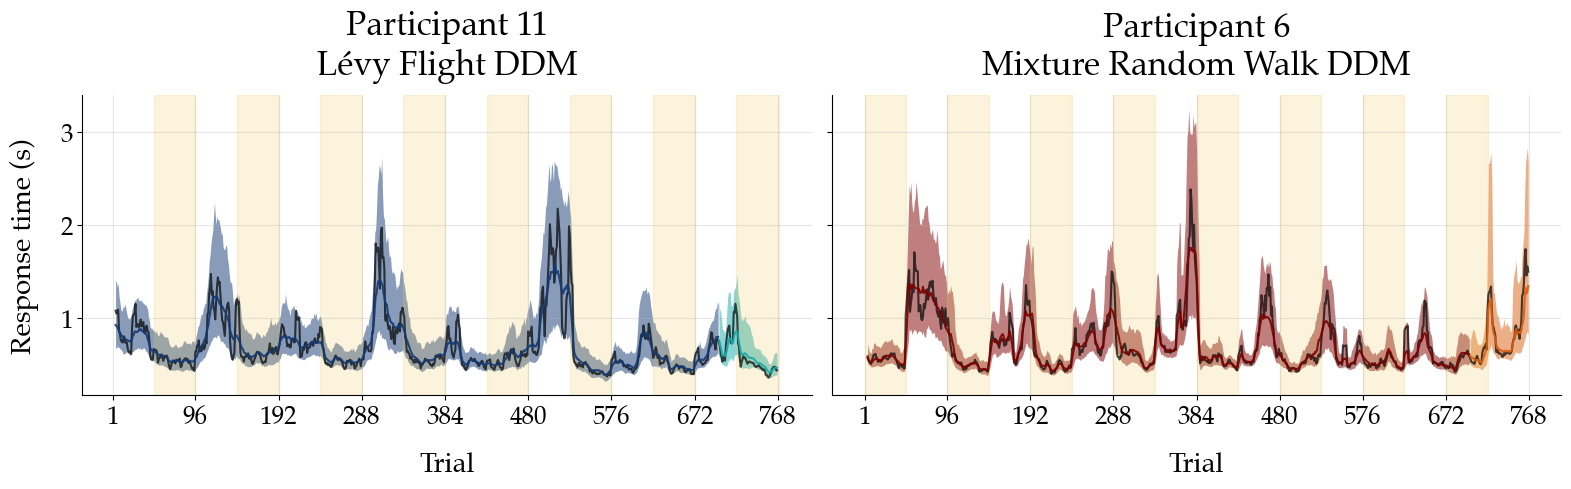

In [46]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
for i, ax in enumerate(axarr.flat):
    time = np.arange(NUM_OBS)
    ax.plot(time, calc_sma(data.rt.loc[data.id == subs[i]].to_numpy()), color='black', alpha=0.7, lw=LINE_WIDTH)
    ax.plot(
        time[:NUM_OBS-HORIZON_SIZE],
        pred_rt_mean[subs[i]-1, :NUM_OBS-HORIZON_SIZE],
        color=COLORS[i], alpha=0.9, lw=LINE_WIDTH
    )
    ax.plot(
        time[NUM_OBS-HORIZON_SIZE:],
        pred_rt_mean[subs[i]-1, NUM_OBS-HORIZON_SIZE:],
        color=PRED_COLORS[i], alpha=0.9, lw=LINE_WIDTH)
    ax.fill_between(
        time[:NUM_OBS-HORIZON_SIZE],
        pred_rt_quantiles[0, subs[i]-1, :NUM_OBS-HORIZON_SIZE],
        pred_rt_quantiles[1, subs[i]-1, :NUM_OBS-HORIZON_SIZE],
        color=COLORS[i], alpha=0.5, linewidth=0.0
    )
    ax.fill_between(
        time[NUM_OBS-HORIZON_SIZE:],
        pred_rt_quantiles[0, subs[i]-1, NUM_OBS-HORIZON_SIZE:],
        pred_rt_quantiles[1, subs[i]-1, NUM_OBS-HORIZON_SIZE:],
        color=PRED_COLORS[i], alpha=0.5, linewidth=0.0
    )
    if i == 0:
        ax.set_ylabel('Response time (s)', fontsize=FONT_SIZE_2, labelpad=LABEL_PAD)
    ax.set_xlabel('Trial', fontsize=FONT_SIZE_2, labelpad=LABEL_PAD)
    ax.set_title(PLOT_TITLE[i], fontsize=FONT_SIZE_1, pad=LABEL_PAD)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    time = np.arange(0, 768+1, 96)
    time[0] = 1
    ax.set_xticks(time)
    ax.grid(alpha=0.3)
    # get conditions
    condition = data.speed_condition.loc[data.id == subs[i]].to_numpy()
    idx_speed = []
    if condition[0] == 1:
        idx_speed.append([0])
        idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
        idx_speed = np.concatenate(idx_speed)
    else:
        idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
        idx_speed.append([NUM_OBS])
        idx_speed = np.concatenate(idx_speed)
    # yellow shades
    x = 0
    while x < idx_speed.shape[0]:
        ax.axvspan(idx_speed[x] + 1, idx_speed[x + 1] + 1, alpha=0.2, color='#f0c654', label="Speed condition")
        x = x + 2
fig.tight_layout()
sns.despine()
fig.savefig("../plots/rt_time_series_resim.jpg", dpi=300, bbox_inches="tight")

In [47]:
subs = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14]

In [48]:
time = np.arange(NUM_OBS)

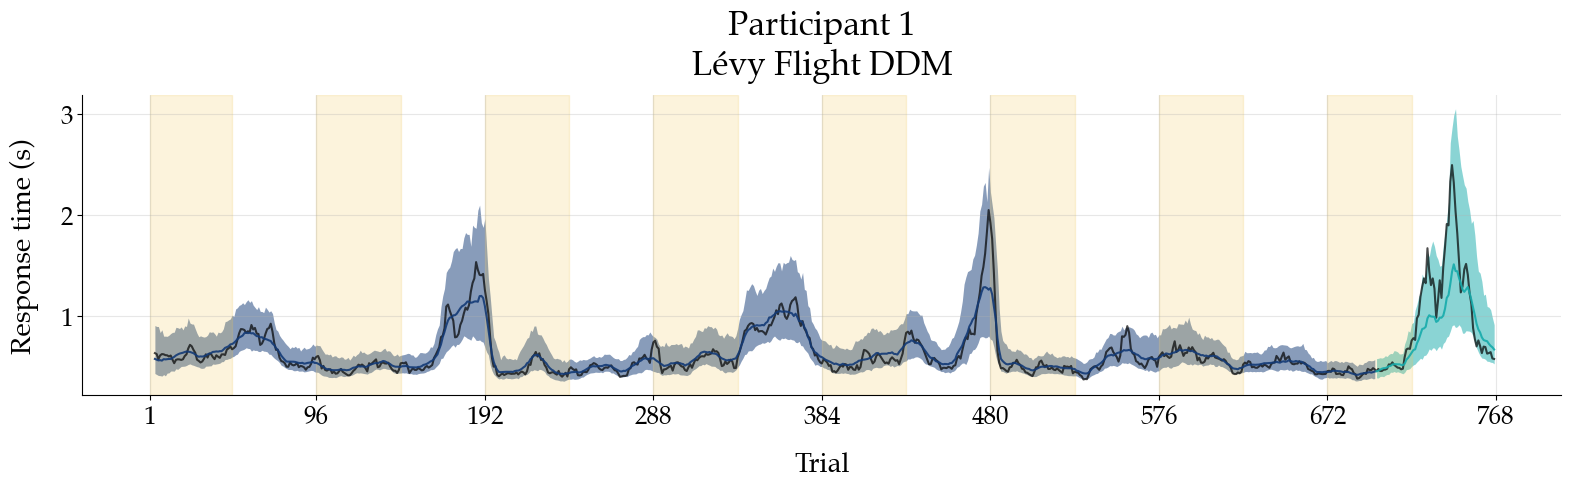

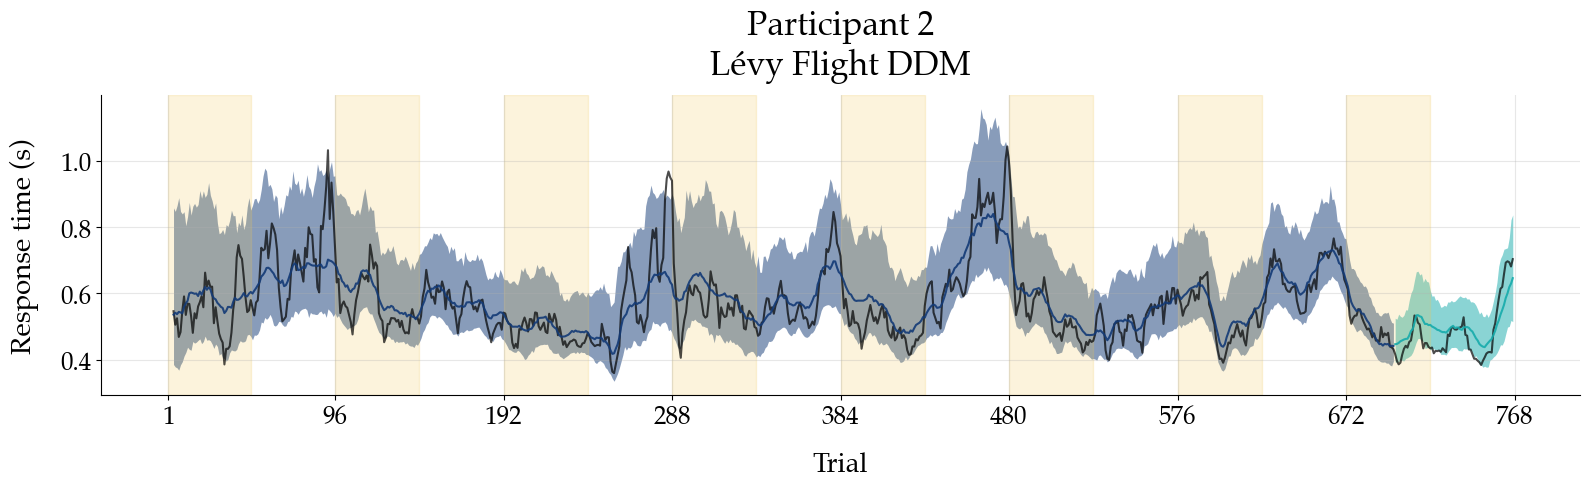

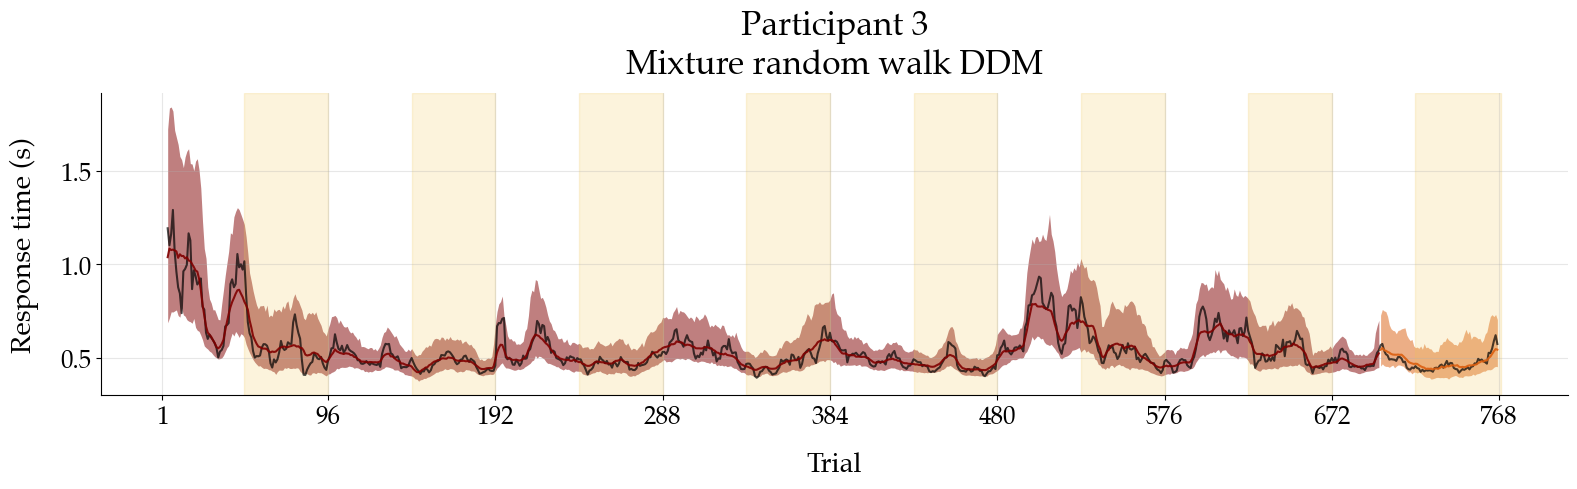

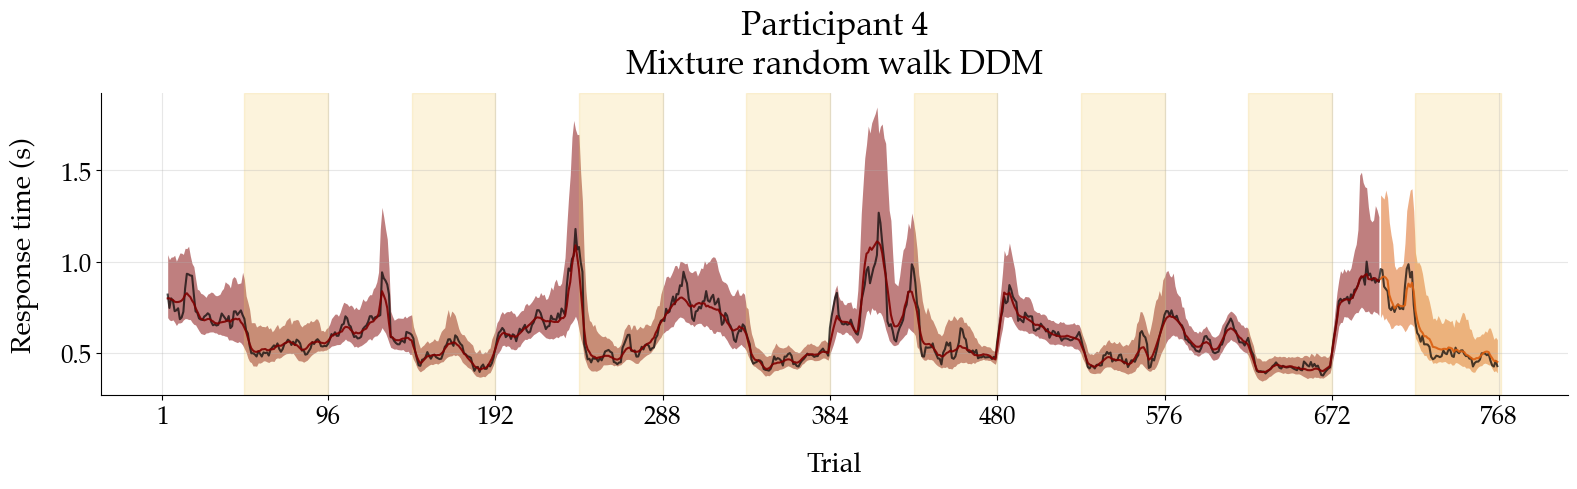

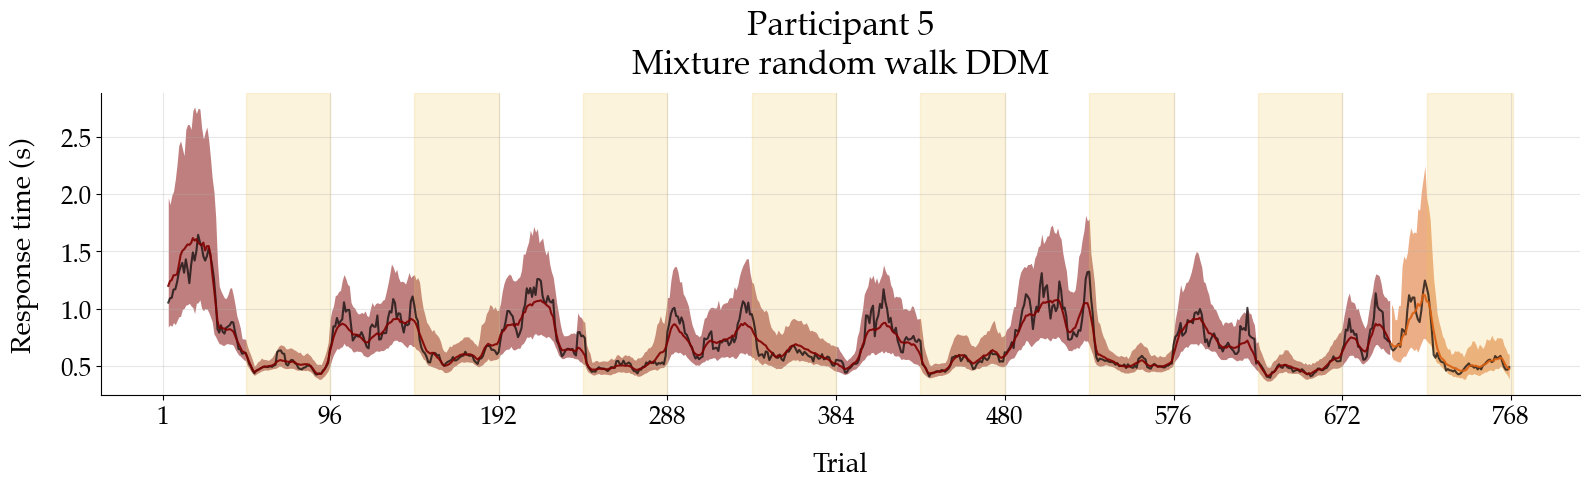

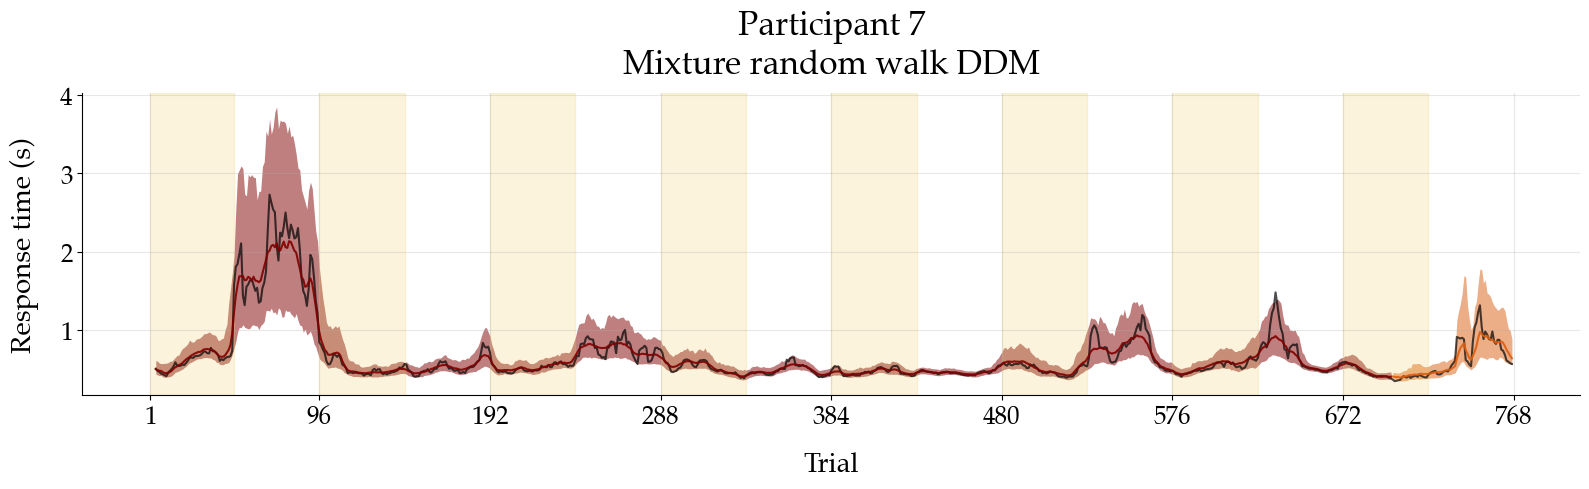

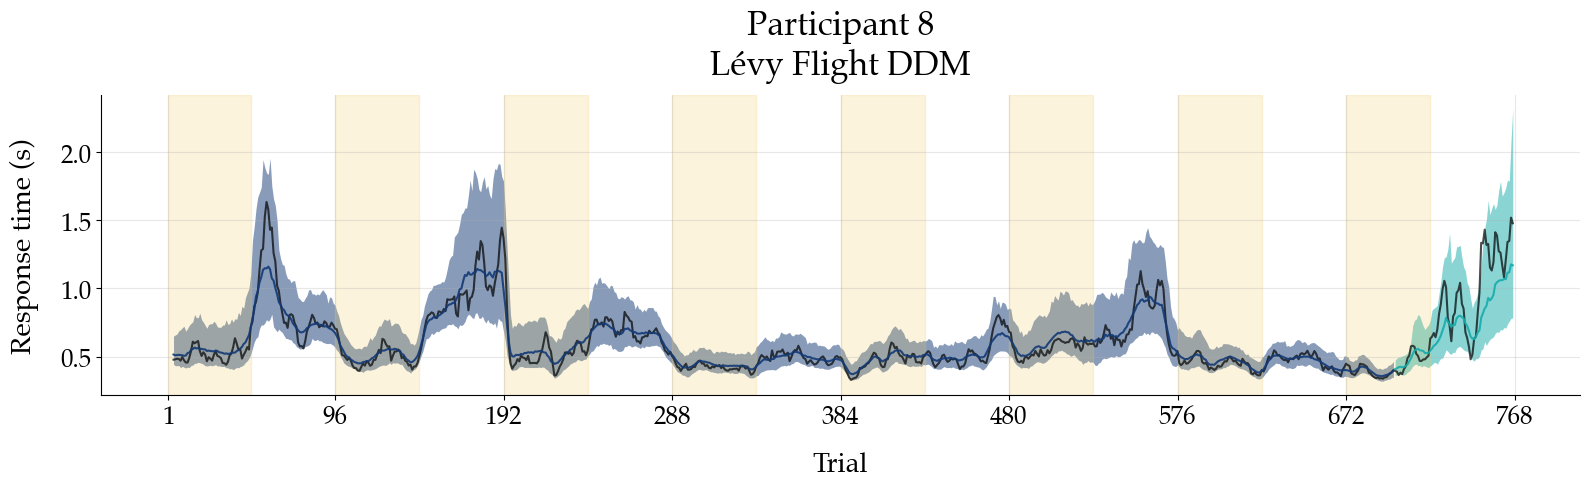

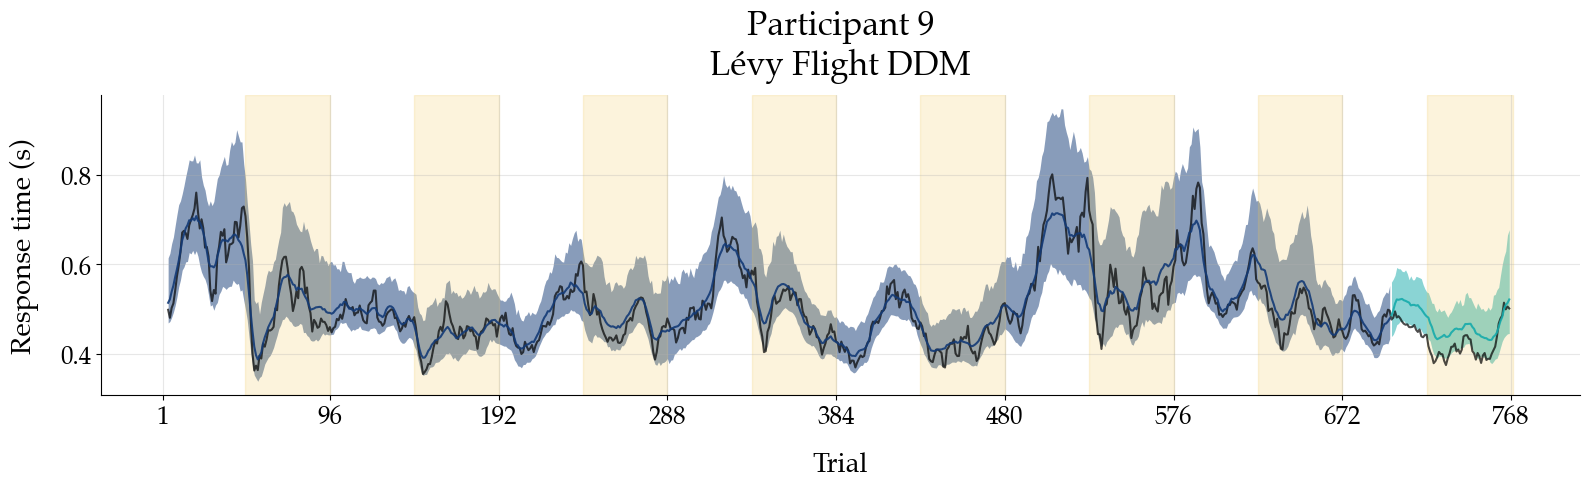

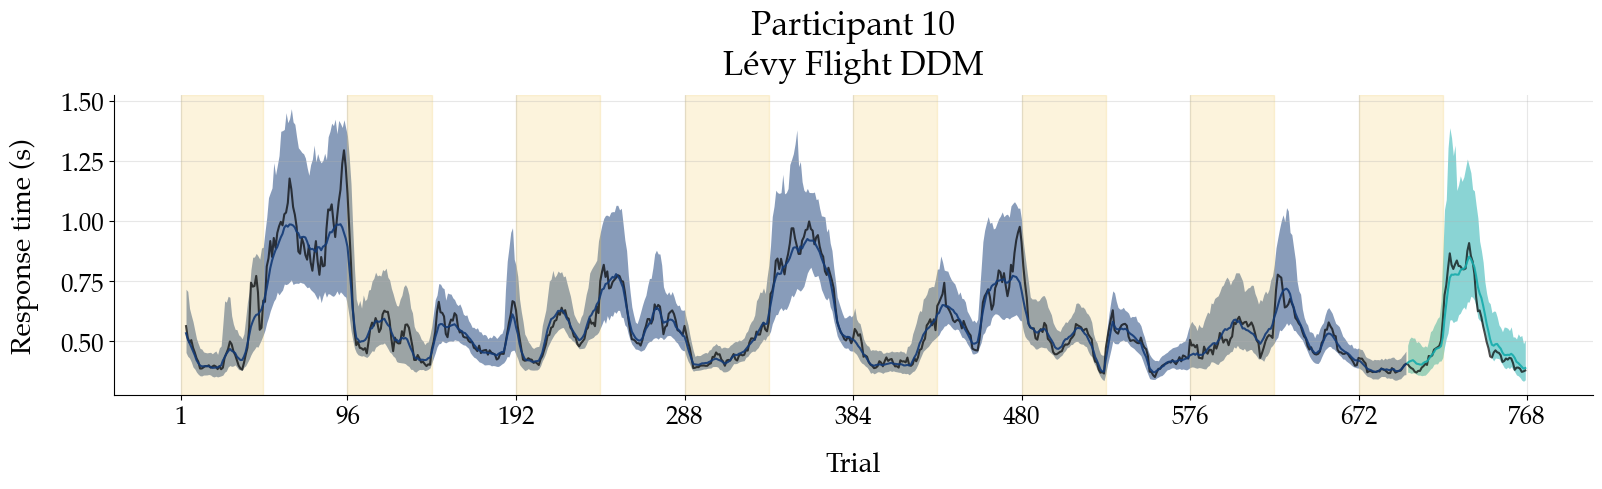

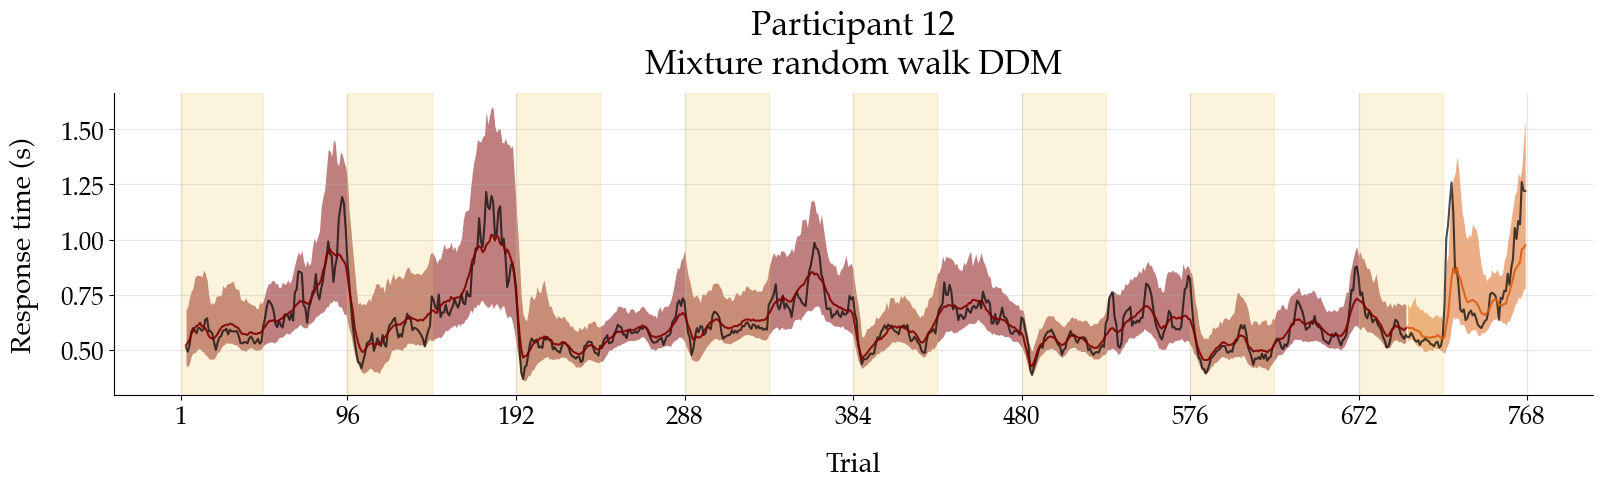

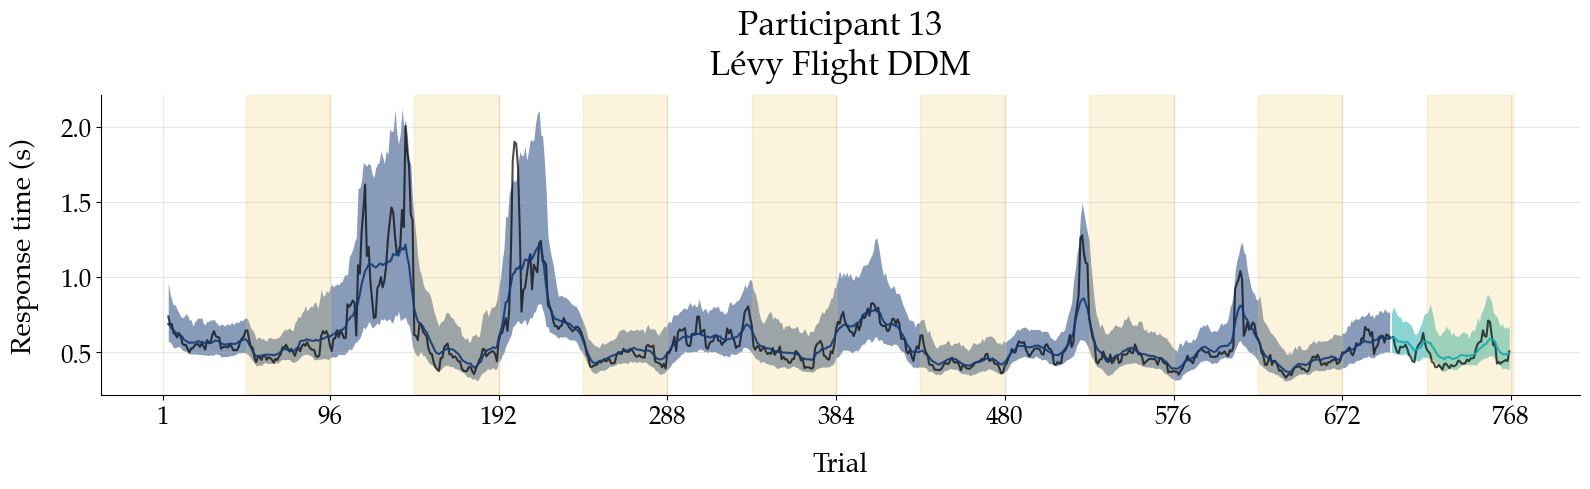

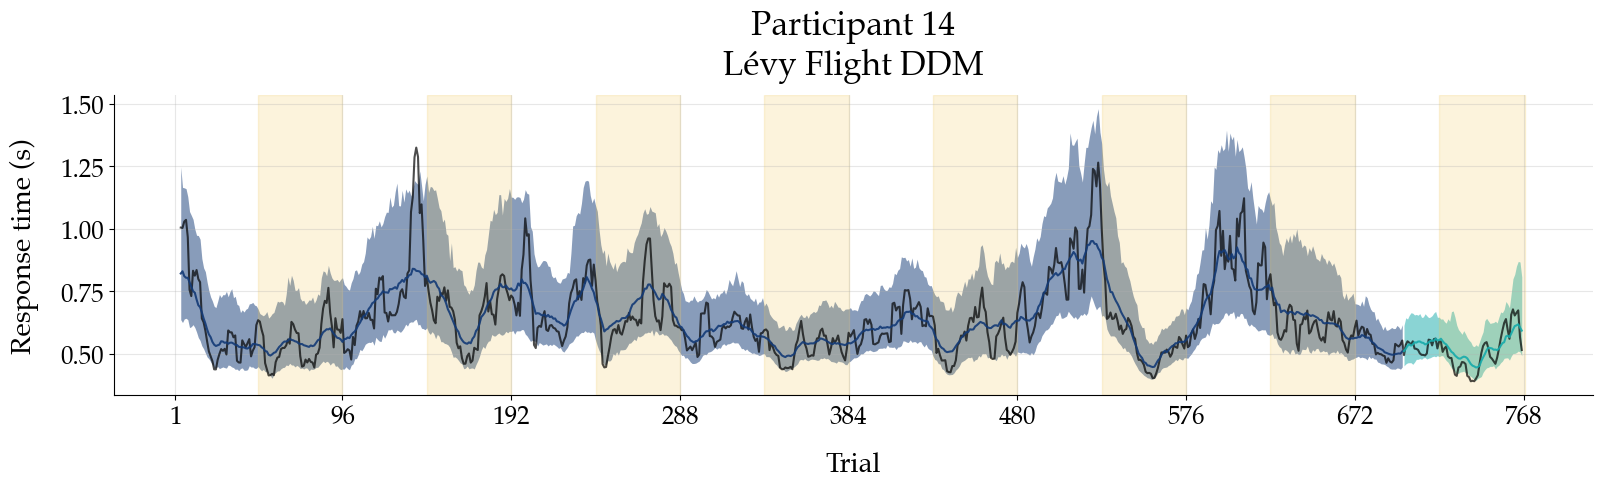

In [49]:
for i, sub in enumerate(subs):
    if winning_model_per_person[i] == 2:
        color = COLORS[0]
        pred_color = PRED_COLORS[0]
        model_type = "Lévy Flight DDM"
    else:
        color = COLORS[1]
        pred_color = PRED_COLORS[1]
        model_type = "Mixture random walk DDM"
    fig, ax = plt.subplots(1, 1, figsize=(16, 5), sharey=True)
    time = np.arange(NUM_OBS)
    ax.plot(time, calc_sma(data.rt.loc[data.id == sub].to_numpy()), color='black', alpha=0.7, lw=LINE_WIDTH)
    ax.plot(
        time[:NUM_OBS-HORIZON_SIZE],
        pred_rt_mean[sub-1, :NUM_OBS-HORIZON_SIZE],
        color=color, alpha=0.9, lw=LINE_WIDTH
    )
    ax.plot(
        time[NUM_OBS-HORIZON_SIZE:],
        pred_rt_mean[sub-1, NUM_OBS-HORIZON_SIZE:],
        color=pred_color, alpha=0.9, lw=LINE_WIDTH)
    ax.fill_between(
        time[:NUM_OBS-HORIZON_SIZE],
        pred_rt_quantiles[0, sub-1, :NUM_OBS-HORIZON_SIZE],
        pred_rt_quantiles[1, sub-1, :NUM_OBS-HORIZON_SIZE],
        color=color, alpha=0.5, linewidth=0.0
    )
    ax.fill_between(
        time[NUM_OBS-HORIZON_SIZE:],
        pred_rt_quantiles[0, sub-1, NUM_OBS-HORIZON_SIZE:],
        pred_rt_quantiles[1, sub-1, NUM_OBS-HORIZON_SIZE:],
        color=pred_color, alpha=0.5, linewidth=0.0
    )
    ax.set_ylabel('Response time (s)', fontsize=FONT_SIZE_2, labelpad=LABEL_PAD)
    ax.set_xlabel('Trial', fontsize=FONT_SIZE_2, labelpad=LABEL_PAD)
    ax.set_title(f"Participant {sub}\n{model_type}", fontsize=FONT_SIZE_1, pad=LABEL_PAD)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    time = np.arange(0, 768+1, 96)
    time[0] = 1
    ax.set_xticks(time)
    ax.grid(alpha=0.3)
    # get conditions
    condition = data.speed_condition.loc[data.id == sub].to_numpy()
    idx_speed = []
    if condition[0] == 1:
        idx_speed.append([0])
        idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
        idx_speed = np.concatenate(idx_speed)
    else:
        idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
        idx_speed.append([NUM_OBS])
        idx_speed = np.concatenate(idx_speed)
    # yellow shades
    x = 0
    while x < idx_speed.shape[0]:
        ax.axvspan(idx_speed[x] + 1, idx_speed[x + 1] + 1, alpha=0.2, color='#f0c654', label="Speed condition")
        x = x + 2
    fig.tight_layout()
    sns.despine()
    fig.savefig(f"../plots/rt_time_series_resim_sub_{sub}.jpg", dpi=300, bbox_inches="tight")